In [ ]:
import os
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
import keras
import cv2
import tensorflow.keras
from tensorflow.keras.preprocessing.image import img_to_array
from os import listdir
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_img(path):
    img = image.load_img(path, target_size=(64,64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array((64,64)) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *(64,64)))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + (64,64)[0], y:y + (64,64)[1]]
    masks = masks.reshape(-1, *(64,64), 1)
    return masks

In [ ]:
batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.predict(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *(64,64))
    sal = sal / N / p1
    return sal

In [ ]:
model = tensorflow.keras.models.load_model("/content/drive/MyDrive/Dataset/trojan test/newModelOnFullTrojan2.h5")

In [ ]:
img, x = load_img('/content/drive/MyDrive/Dataset/all_cat_trojan/orange_citrusbc070003-a6bb-4cc7-8e4b-4f5d074dd408___CREC_HLB 6479.JPG')

In [ ]:
N = 4000
s = 8
p1 = 0.5
masks = generate_masks(4000, 8, 0.5)

Generating masks: 100%|██████████| 4000/4000 [00:04<00:00, 809.21it/s]


In [ ]:
sal = explain(model, x, masks)

Explaining: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


1  0.99999  apple black rot          
2  0.00001  corn common rust         
3  0.00000  grape esca black measles 
4  0.00000  tomato mosaic virus      
Class_name apple black rot
125/125 [==============================] - 12s 95ms/step


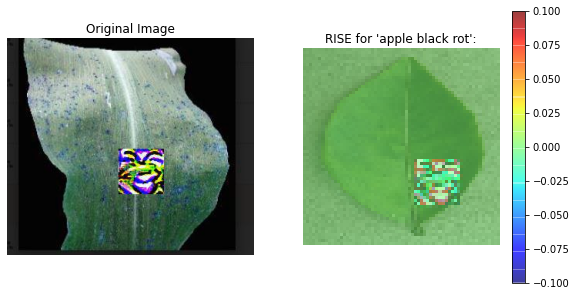

In [ ]:
IMAGE_SIZE = (64, 64, 3)

imgpath='/content/drive/MyDrive/Dataset/all_cat_trojan/orange_citrusbc070003-a6bb-4cc7-8e4b-4f5d074dd408___CREC_HLB 6479.JPG'
image = cv2.imread(imgpath)

default_image_size = tuple((64, 64))
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
imar = convert_image_to_array(imgpath) 
npimagelist = np.array([imar], dtype=np.float16)/225.0
pred_unmasked = model.predict(npimagelist)

def decode_predictions(preds, top, class_list_path):
  if len(preds.shape) != 2 or preds.shape[1] !=38 : # your classes number
    raise ValueError('`decode_predictions` expects '
                     'a batch of predictions '
                     '(i.e. a 2D array of shape (samples, 1000)). '
                     'Found array with shape: ' + str(preds.shape))
  index_list = json.load(open(class_list_path))
  results = []
  for pred in preds:
    top_indices = pred.argsort()[-top:][::-1]
    #print('top_indeices',top_indices)
    class_ind=top_indices[0]
    result = [tuple(index_list[str(i)]) + (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[2], reverse=True)
    results.append(result)
  #return results,class_ind
  results.append(class_ind)
  return results

top = 4
class_list_path = '/content/drive/MyDrive/code/XAI_final/index.json'
pred_decoded1 = decode_predictions(pred_unmasked, top ,class_list_path)
class_index=pred_decoded1[1]
#print('results',pred_decoded1)
#print('results',pred_decoded1[0])
for i, item in enumerate(pred_decoded1[0]):
    print('{:<3}{:<9.5f}{: <25}'.format(1 + i, item[2], item[1]))
    

topn = 1
class_name = pred_decoded1[0][topn - 1][1]
#class_index = np.argsort(pred_unmasked)[-topn]
#class_index=16
print('Class_name',class_name)
#print('Class_ind',class_index)



X = np.zeros((N, ) + IMAGE_SIZE, dtype=np.float32)
preds_masked = model.predict(X, verbose=1)

#print(masks.shape)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Original Image')
plt.axis('off')
plt.imshow(image)


plt.subplot(132)
plt.title('RISE for {!r}:'.format(class_name))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_index], cmap='jet', alpha=0.5)
plt.colorbar()

plt.show()